In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import copy

from skimage.measure import block_reduce


#For plotting
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.rcParams["animation.html"] = "jshtml"
mpl.rcParams['figure.facecolor'] = 'white'
plt.rcParams["image.origin"] = "lower"


from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import Common, IPythonMagic, PlotHelper

In [2]:
%cuda_context_handler gpu_ctx

In [3]:

def initGridSpecs(l):
    data_args = {}
    data_args["nx"] = 2**l
    data_args["ny"] = 2**(l+1) 

    data_args["dx"] = 2**(19-l)*100/2
    data_args["dy"] = 2**(19-l)*100/2

    return data_args


def initBump(l, l_max, d_shift=1e6,D=0.5*1e6):

    data_args_max = initGridSpecs(l_max)
    nx, ny = data_args_max["nx"], data_args_max["ny"]

    dx, dy = data_args_max["dx"], data_args_max["dy"]

    eta0  = np.zeros((ny,nx), dtype=np.float32, order='C')
    x_center = dx*nx*0.5
    y_center = dy*ny*0.5

    xm = nx//2
    ym = ny//2

    xit_start = nx//8
    yit_start = ny//16

    for j in range(ym-yit_start, ym+yit_start):
        for i in range(xm-xit_start, xm+xit_start):
            x = dx*i - x_center
            y = dy*j - y_center

            d = np.sqrt(x**2 + y**2)
            
            eta0[j, i] += 0.1*(1.0+np.tanh(-(d-d_shift)/D))

    eta0 = block_reduce(eta0, block_size=(2**(l_max-l),2**(l_max-l)), func=np.nanmean)
    eta0 = np.pad(eta0, ((2,2),(2,2)))

    hu0 = np.zeros_like(eta0, dtype=np.float32)

    hv0 = np.zeros_like(eta0, dtype=np.float32)

    return eta0, hu0, hv0


def initLevel(l, l_max=None):
    if l_max is None:
        l_max = l 

    data_args = initGridSpecs(l)
    dataShape = (data_args["ny"] + 4, data_args["nx"] + 4)

    data_args["dt"] = 0.0
    data_args["g"] = 9.81
    data_args["f"] = 1.2e-4
    data_args["r"] = 0.0
    # data_args["boundary_conditions"] = Common.BoundaryConditions(1,1,1,1)

    data_args["eta0"], data_args["hu0"], data_args["hv0"] = initBump(l, l_max)
    
    H0 = 1000.0
    data_args["H"] = np.ma.array(np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')*H0, mask=False)

    return data_args

In [4]:
T = 250000/2

In [5]:
data_args1 = initLevel(7, 10)
data_args1["eta0"].shape

(260, 132)

In [6]:
data_args1["dx"], data_args1["dy"], data_args1["f"], data_args1["nx"], data_args1["ny"], np.max(data_args1["eta0"])

(204800.0, 204800.0, 0.00012, 128, 256, 0.19363701)

In [7]:
def run_level(l):
    data_args1 = initLevel(l, 10)


    sim = CDKLM16.CDKLM16(gpu_ctx, **data_args1)

    sim.step(T/2)

    plt.plot(data_args1["eta0"][data_args1["ny"]//2,:])

    plt.figure()
    plt.imshow(data_args1["eta0"], origin="lower", vmin=-0.0001, vmax=0.0001)
    plt.colorbar()

    eta, hu, hv = sim.download()

    plt.figure()
    plt.imshow(eta, origin="lower")
    plt.colorbar()


    plt.figure()
    plt.imshow(hu, origin="lower")
    plt.colorbar()

    sim.step(T/2)

    eta, hu, hv = sim.download()

    plt.figure()
    plt.imshow(eta, origin="lower")
    plt.colorbar()


    plt.figure()
    plt.imshow(hu, origin="lower")
    plt.colorbar()

    

    print("dt: " + str(sim.dt))

In [8]:
data_args1 = initLevel(10, 10)


sim = CDKLM16.CDKLM16(gpu_ctx, **data_args1)

sim.step(T)
eta, hu, hv = sim.download(interior_domain_only=True)

print(eta[600, 400], hu[600, 400], hv[600, 400])


C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


0.0017661867 -0.45544025 -0.027695


dt: 51.688366699218754


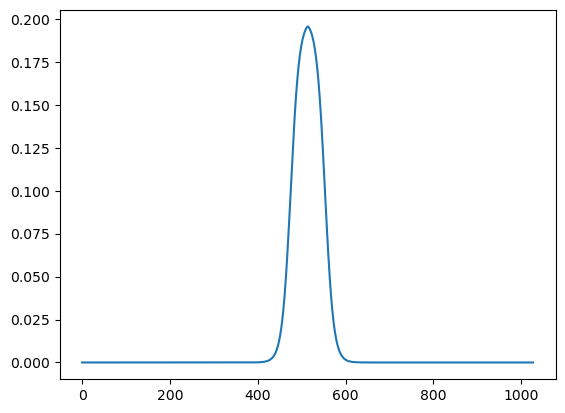

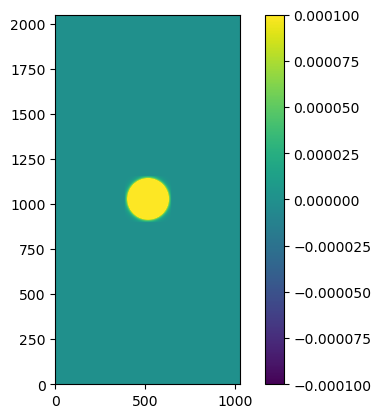

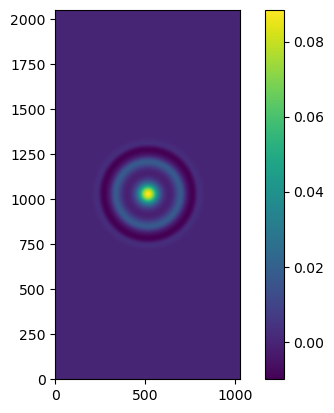

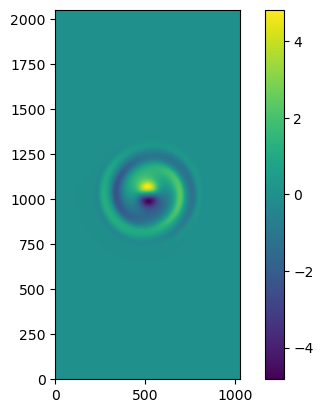

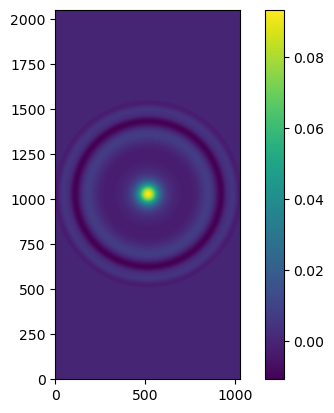

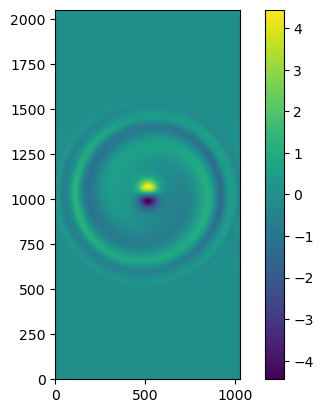

In [9]:
run_level(10)

C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


dt: 103.3767578125


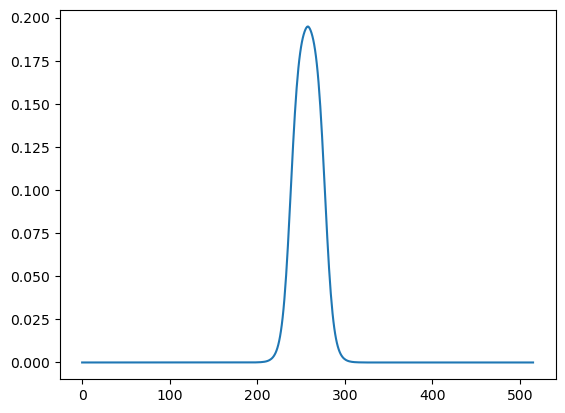

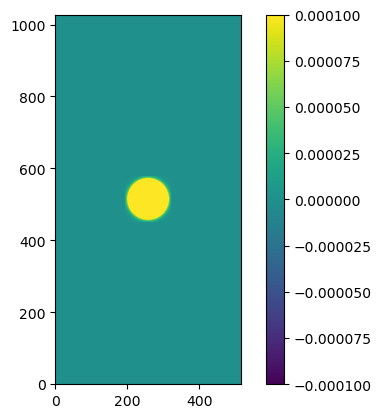

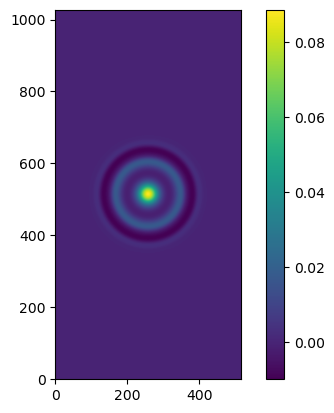

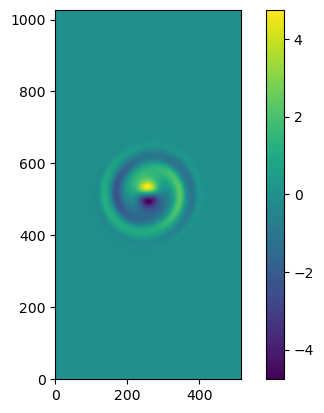

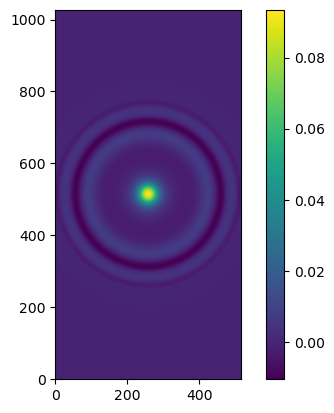

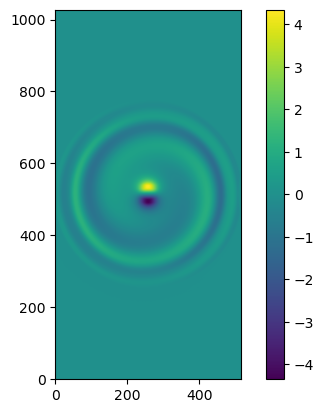

In [10]:
run_level(9)

C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


dt: 206.75356445312502


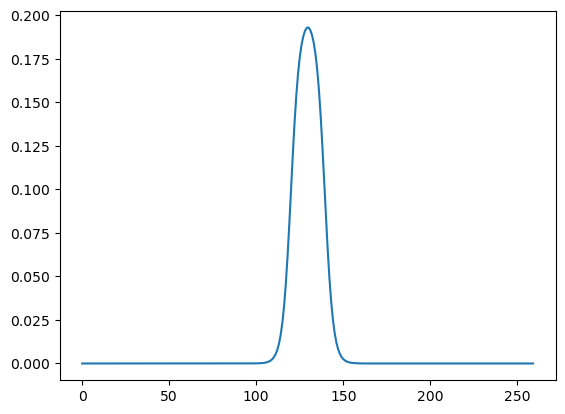

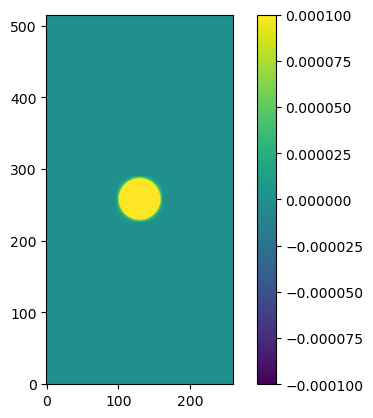

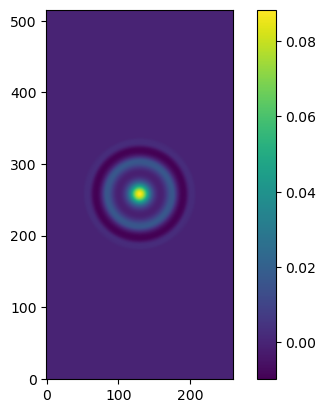

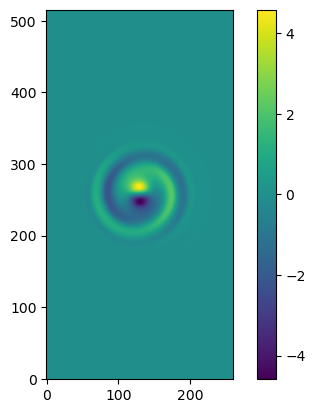

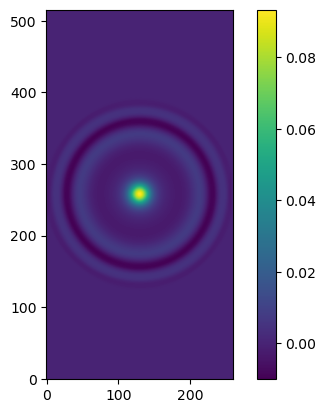

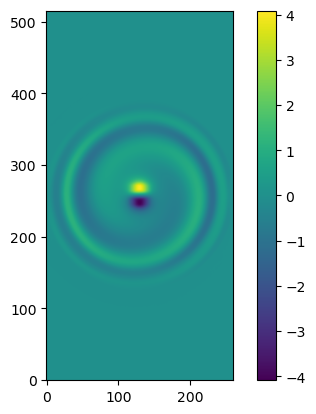

In [11]:
run_level(8)

C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


dt: 413.507470703125


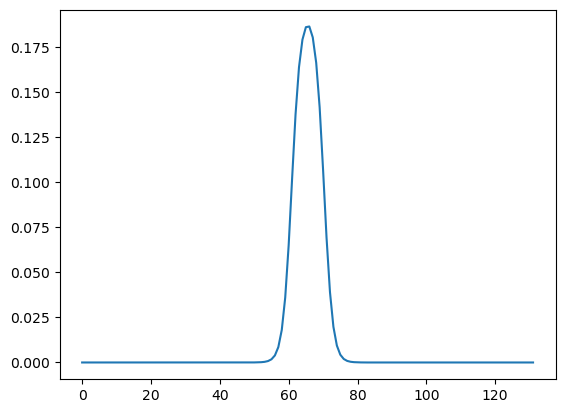

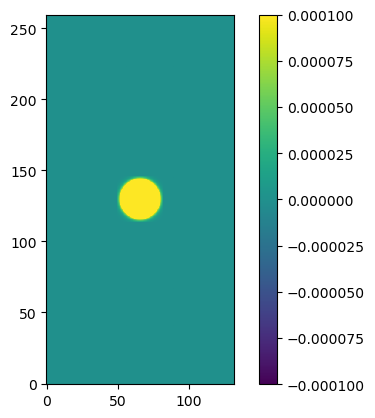

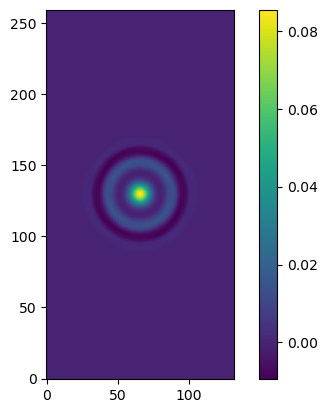

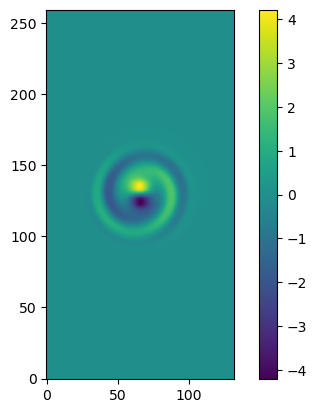

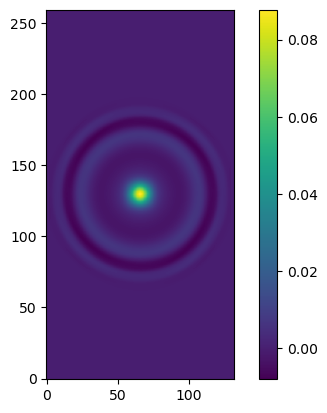

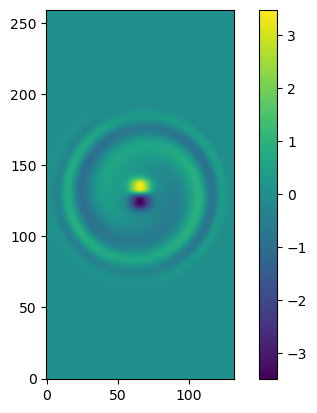

In [12]:
run_level(7)

C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


dt: 827.01748046875


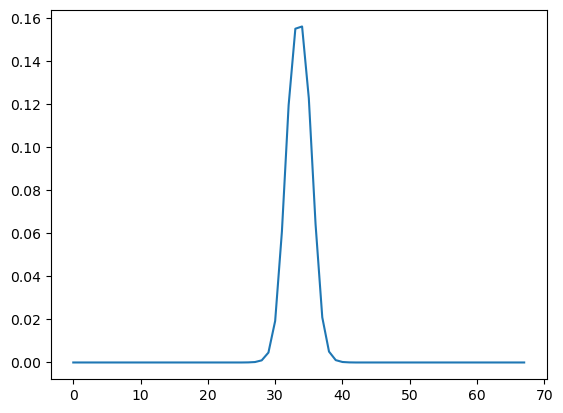

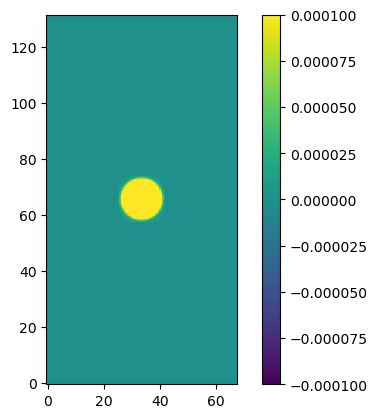

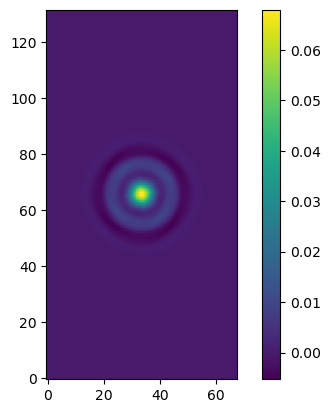

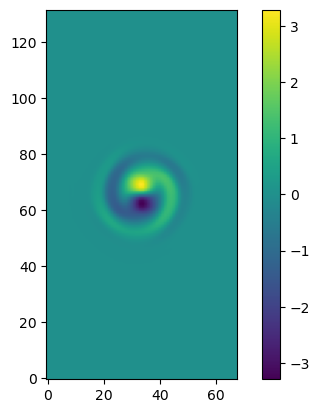

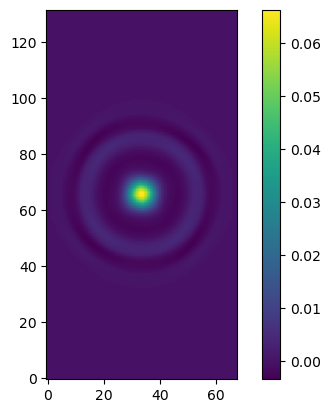

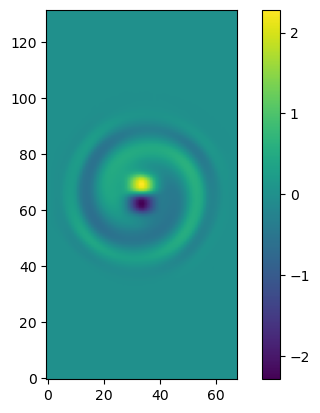

In [13]:
run_level(6)

dt: 1654.059375


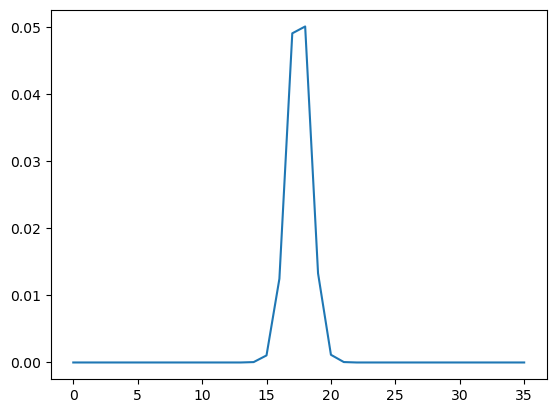

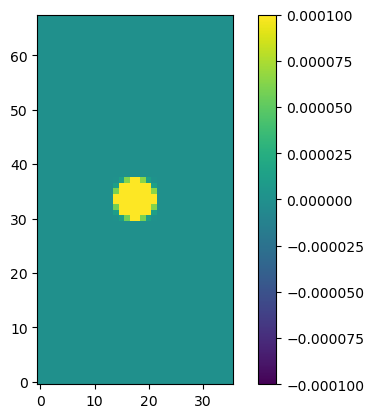

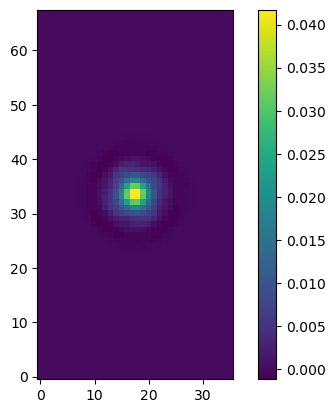

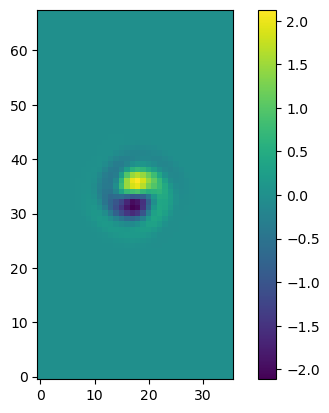

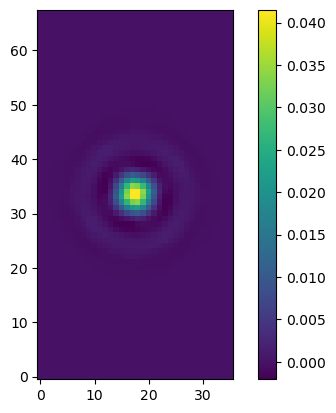

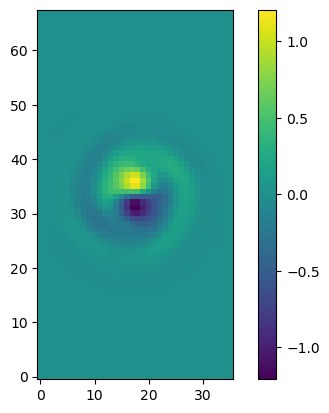

In [15]:
run_level(5)

C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


dt: 3308.26484375


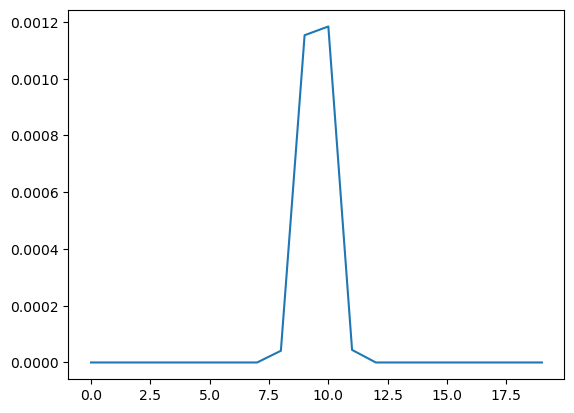

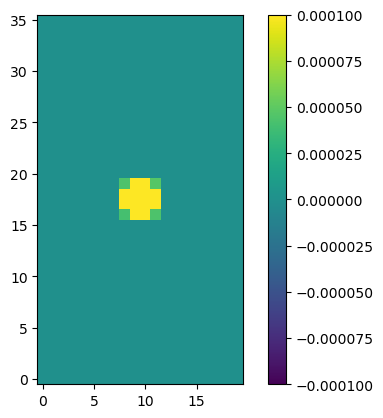

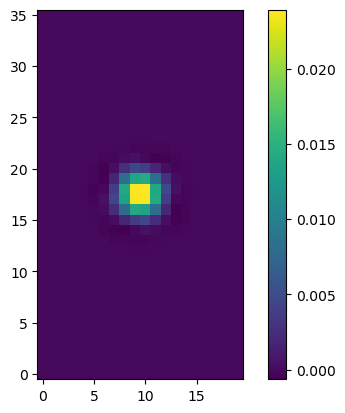

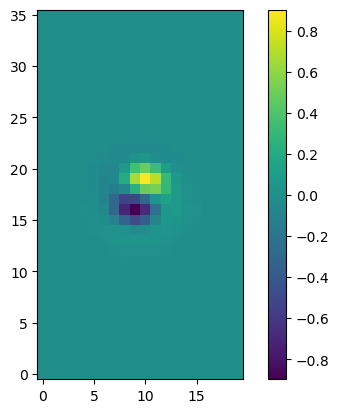

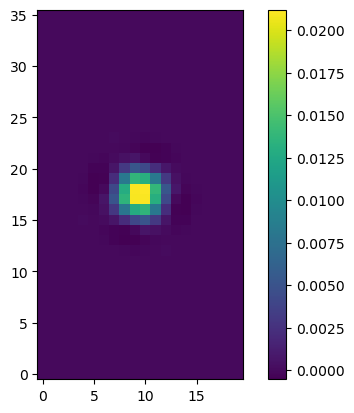

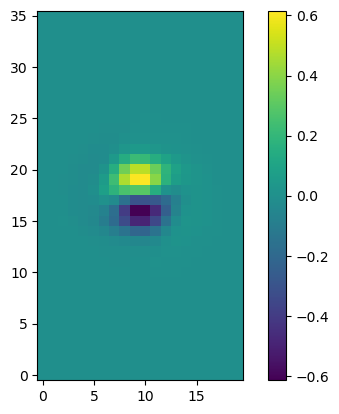

In [16]:
run_level(4)

C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\SWEsimulators\CDKLM16.py:216: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  jit_compile_args={


dt: 26467.028125


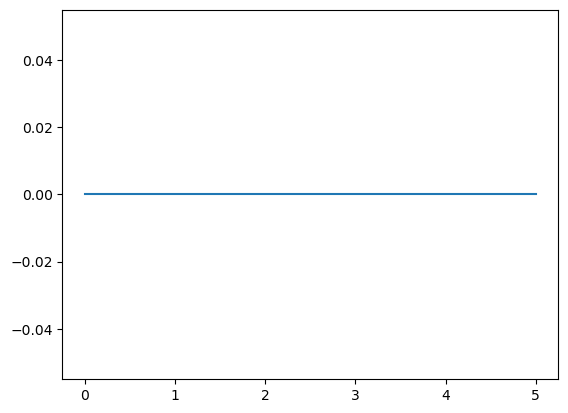

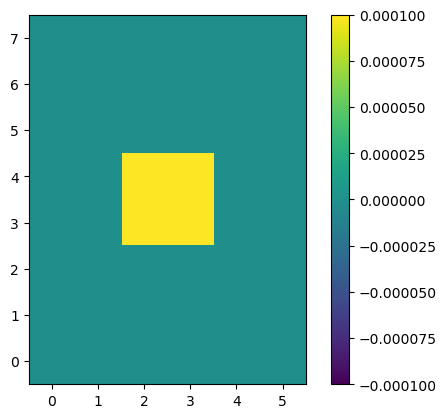

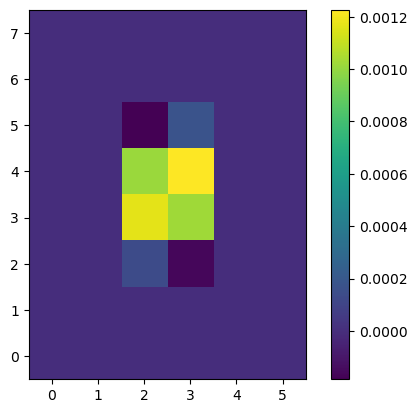

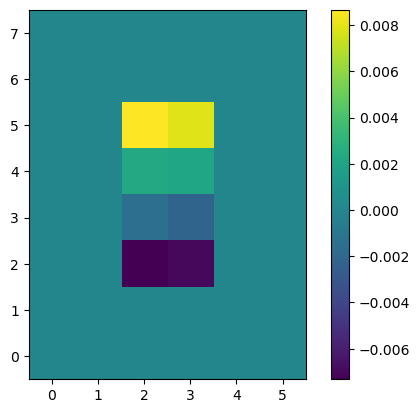

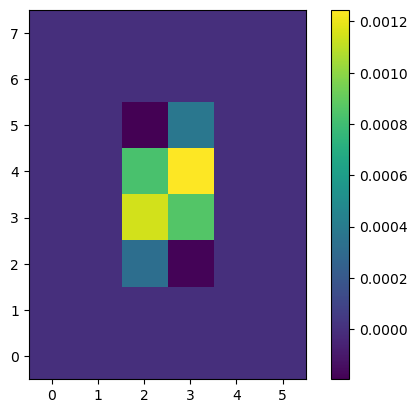

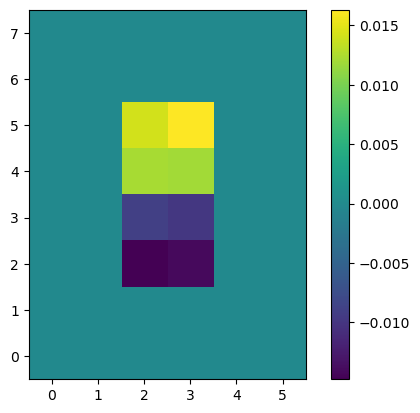

In [19]:
run_level(1)